# **Artistic style transfer using two styles analysis**

This file is almost equal to the ATS Mix 2 Styles file but with an added analysis for gamma values at the end.

## **Imports**

*   torch, torch.nn, numpy (indispensables packages for neural networks with PyTorch)
*   torch.optim (efficient gradient descents)
* PIL, PIL.Image, matplotlib.pyplot (load and display images)
* torchvision.transforms (transform PIL images into tensors)
* torchvision.models (train or load pre-trained models)
*copy (to deep copy the models; system package)

In [ ]:
from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2022/Final_Project/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2022/Final_Project/Results/'

Mounted at /content/drive


In [ ]:
style1_name = "Picasso"
style2_name = "ColorfulNight"
content_name = "TajMahal"
style1_img_path = data_path + "/Styles/" + style1_name + ".jpg"
style2_img_path = data_path + "/Styles/" + style2_name + ".jpg"
content_img_path = data_path + "/Contents/" + content_name + ".jpg"
content_mask_img_path = data_path + "/Contents/" + content_name + "Mask" + ".jpg"

torch.cuda.empty_cache()

## **Loading the images**

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1 (float values). The images also need to be resized to have the same dimensions. To do that we have taken the some fixed dimensions (so that both would be resised).

An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style.

In [ ]:
# desired size of the output image
imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

content = Image.open(content_img_path)
width = content.size[0] 
height = content.size[1]
aspect_ratio = width / height


loader = transforms.Compose([
    transforms.Resize((imsize, int(aspect_ratio*imsize))),  # scale imported image # TODO resize properly
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    print(image.size)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style1_img = image_loader(style1_img_path)
style2_img = image_loader(style2_img_path)
content_img = image_loader(content_img_path)
mask_img = image_loader(content_mask_img_path)

print(style1_img.size())
print(style2_img.size())
print(content_img.size())
print(mask_img.size())
assert style1_img.size() == content_img.size() == style2_img.size() == mask_img.size(), \
    "we need to import style and content images of the same size"

(650, 650)
(1259, 837)
(1200, 748)
(633, 394)
torch.Size([1, 3, 1024, 1642])
torch.Size([1, 3, 1024, 1642])
torch.Size([1, 3, 1024, 1642])
torch.Size([1, 3, 1024, 1642])


## **Displaying the images**

Now, let’s create a function that displays an image by reconverting a copy of it to PIL format and displaying the copy using plt.imshow. We will try displaying the content and style images to ensure they were imported correctly.

It will print the images for this case below.

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None, save=False):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    print(image.size())
    image = unloader(image)
    if save == True:
      ct = datetime.datetime.now()
      image.save(results_path + style1_name + style2_name + content_name + str(ct) + ".png")
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure(figsize=(32,12))
imshow(style1_img, title='Style1 Image')
plt.figure(figsize=(32,12))
imshow(style2_img, title='Style2 Image')
plt.figure(figsize=(32,12))
imshow(content_img, title='Content Image')

Output hidden; open in https://colab.research.google.com to view.

## **Loss Functions**




### Content Loss

The content loss is a function that represents a weighted version of the content distance for an individual layer. In this case it analyses the distance between the content image and the one resulting after the iteration (output one).

We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. Now, in order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

The style loss module is implemented similarly as the content loss module. In this case, we are computing how much the style image and the output one differ after each iteration.

It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. A gram matrix is the result of multiplying a given matrix by its transposed matrix.

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss module. The style distance is also computed using the mean square error

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## **The Model**

Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper. We will only be using it to reduce the error rate.

PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img1, style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses1 = []
    style_losses2 = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature1 = model(style_img1).detach()
            target_feature2 = model(style_img2).detach()
            style_loss1 = StyleLoss(target_feature1)
            style_loss2 = StyleLoss(target_feature2)
            model.add_module("style_loss_1{}".format(i), style_loss1)
            style_losses1.append(style_loss1)
            model.add_module("style_loss_2{}".format(i), style_loss2)
            style_losses2.append(style_loss2)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses1, style_losses2, content_losses

Next, we select the input image. You can use a copy of the content image or white noise.  We have chosen to use the first one.

torch.Size([3, 1024, 1642])


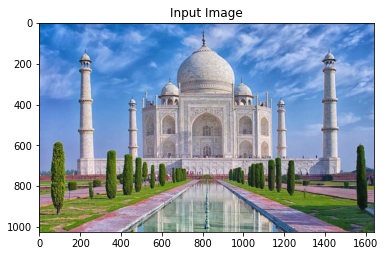

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## **Gradient Descent**

As Leon Gatys, the author of the algorithm, suggested, we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

Remark that BFGS is an optimization method that obtains the minimum of a given function without using a lot of memory.

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img1, style_img2, input_img, num_steps=300,
                       style_weight=1000000, style_weight2=0.5, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses1, style_losses2, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img1, style_img2, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    style1_list_loss = []
    style2_list_loss = []
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score1 = 0
            style_score2 = 0
            content_score = 0

            for sl1 in style_losses1:
                style_score1 += sl1.loss
            for sl2 in style_losses2:
                style_score2 += sl2.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score1 *= style_weight*style_weight2
            style_score2 *= style_weight*(1-style_weight2)
            content_score *= content_weight

            loss = style_score1 + style_score2 + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss1 : {:4f} Style Loss2 : {:4f} Content Loss: {:4f}'.format(
                    style_score1.item(), style_score2.item(), content_score.item()))
                print()
            style1_list_loss.append(style_score1.item())
            style2_list_loss.append(style_score2.item())

            return style_score1 + style_score2 + content_score

        
        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    style1 = style1_list_loss[-1]/style1_list_loss[0]
    style2 = style2_list_loss[-1]/style2_list_loss[0]

    return input_img, style1, style2

Finally we can run the algorithm applying two style images simultaneously to a content image.

In this first cell we compute the content losses for different gamma values.

In [ ]:
iterations = 100
alpha = 1   # content weight 
beta = 10000000 # style weight
style1_loss = []
style2_loss = []
gamma_vals = []
for gamma in np.arange(0.1,1,0.05):
    print('Computing loss of the model with gamma {:4f}'.format(gamma))
    output1, style1, style2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img, num_steps = iterations,
                             style_weight=beta, style_weight2=gamma, content_weight=alpha)
    gamma_vals.append(gamma)
    style1_loss.append(style1)
    style2_loss.append(style2)
    '''if gamma*10 % 2 != 0:
        plt.figure(figsize=(20,8))
        imshow(output1, title='gamma = {:4f}'.format(gamma), save = True)'''

Computing loss of the model with gamma 0.100000
Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss1 : 12057.991211 Style Loss2 : 4045.973145 Content Loss: 19.174194

run [100]:
Style Loss1 : 12416.676758 Style Loss2 : 2129.040039 Content Loss: 23.594959

Computing loss of the model with gamma 0.150000
Building the style transfer model..
Optimizing..
run [50]:
Style Loss1 : 16527.232422 Style Loss2 : 3185.854980 Content Loss: 23.099916

run [100]:
Style Loss1 : 16530.769531 Style Loss2 : 3105.991943 Content Loss: 22.897715

Computing loss of the model with gamma 0.200000
Building the style transfer model..
Optimizing..
run [50]:
Style Loss1 : 19544.050781 Style Loss2 : 4981.144043 Content Loss: 21.660057

run [100]:
Style Loss1 : 19519.671875 Style Loss2 : 4969.683105 Content Loss: 21.004173

Computing loss of the model with gamma 0.250000
Building the style transfer model..
Optimizing..
run [50]:
Style Loss1 : 21458.310547 Style Loss2 : 7189.763184 Content Loss: 19.639860

run [100]:
Style Loss1 : 21400.189453 Style Loss2 : 7226.142090 Content Loss:

Finally, we can plot the losses values in a logarithmic scale and also the ratio between them.

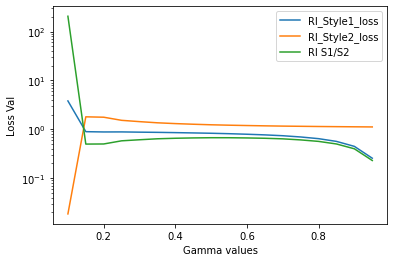

In [ ]:
plt.plot(gamma_vals, style1_loss)
plt.plot(gamma_vals, style2_loss)
plt.plot(gamma_vals, [i / j for i, j in zip(style1_loss, style2_loss)])
plt.xlabel('Gamma values')
plt.yscale('log')
plt.ylabel('Loss Val')
plt.legend(['RI_Style1_loss', 'RI_Style2_loss', 'RI S1/S2'])
plt.show()